<a href="https://colab.research.google.com/github/kirillkobychev/HSE-ML-TEAM-4/blob/master/Project_Music_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

Кобычев Кирилл, @hikoby

Иванов Егор, @Jaibesiondaide

Игорь Земенков, @iZemM

https://github.com/kirillkobychev/HSE-ML-TEAM-4

## Импорт библиотек, установка констант

In [1]:
%%capture
!pip install catboost -q
!pip install ydata-profiling
!pip install --quiet tls-client tqdm
!pip install lightgbm -q
!pip install optuna -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

from ydata_profiling import ProfileReport
import tls_client, difflib, time, random, re
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import HTML

In [3]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [5]:
# @title HTML
def display_card(title, value):
    html = f"""
    <div style='background-color: #f5f5f5; border-radius: 10px; padding: 20px; width: 200px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);'>
        <p style='font-size: 14px; color: #888; margin: 0;'>{title}</p>
        <h1 style='font-size: 36px; color: #000; margin: 10px 0;'>{value}</h1>
    </div>
    """
    return html

# Функция для отображения карточек рядом
def display_flex_cards(cards):
    html = """
    <div style='display: flex; gap: 10px;'>
    """  # Изменено gap с 20px на 10px
    for title, value in cards:
        html += display_card(title, value)
    html += "</div>"
    return HTML(html)

## Загрузка и обзор данных

In [6]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [7]:
train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
5375,32097.0,Colorado,0.45300,0.905,206500.0,0.562,0.000285,G#,0.130,-7.884,Major,0.0662,139.997,4-Apr,0.5070,Rap
4321,22143.0,Zendaya (feat. J. Cole),0.19000,0.702,258166.0,0.891,0.000000,G#,0.154,-3.280,Minor,0.3610,78.876,4-Apr,0.5170,Rap
199,83288.0,Symphony No. 1: I. Allegro assai,0.93400,0.218,827840.0,0.135,0.905000,F,0.105,-20.525,Minor,0.0376,112.254,4-Apr,0.0386,Classical
20150,75338.0,Furious Angels,0.00281,0.507,356160.0,0.811,0.462000,G,0.113,-6.863,Minor,0.0391,114.307,4-Apr,0.4290,Electronic
901,64786.0,Little Miss Lover,0.05490,0.530,-1.0,0.916,0.000302,C#,0.300,-5.643,Major,0.0810,98.722,4-Apr,0.9050,Blues


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
**`key` - тональность**  
`liveness` - привлекательность  
`loudness` - громкость  
**`mode` - наклонение**  
`speechiness` - выразительность  
**`tempo` - темп**  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

Список уникальных значений типа Object

Количество пропущенных значений признаков типа: Object&Float

In [8]:
print("Train unique")
[print(f"{i}: {train[i].unique()}") for i in train.columns if train[i].dtype == 'object']
print("\nTest unique")
[print(f"{i}: {test[i].unique()}") for i in test.columns if test[i].dtype == 'object']

Train unique
track_name: ['Highwayman' 'Toes Across The Floor' 'First Person on Earth' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']
key: ['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']
mode: ['Major' 'Minor' nan]
obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']
music_genre: ['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']

Test unique
track_name: ['Low Class Conspiracy' 'The Hunter' 'Hate Me Now' ... 'Bipolar'
 'Dead - NGHTMRE Remix'
 'A Night In Tunisia - Remastered 1998 / Rudy Van Gelder Edition']
key: ['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
mode: ['Minor' 'Major' nan]
obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']


[None, None, None, None]

In [9]:
print("Train null")
[print(f"{i} ({train[i].dtype}): {train[i].isnull().sum()}") for i in train.columns if train[i].isnull().sum() > 0]
print("Train data shape:", train.shape)
print("\nTest null")
[print(f"{i} ({test[i].dtype}): {test[i].isnull().sum()}") for i in test.columns if test[i].isnull().sum() > 0]
print("Test data shape: ", test.shape)

Train null
key (object): 735
mode (object): 506
tempo (float64): 442
Train data shape: (20394, 16)

Test null
key (object): 158
mode (object): 149
tempo (float64): 121
Test data shape:  (5099, 15)


Заполняем пропуски с помощью сервиса Tunebat, который имеет доступ к API Spotify. Парсим данные признаков: {"key"; "mode"; "tempo"} к каждой композиции. Время выполнения ячейки ниже занимает ~3 часа, при этом мы не избавляемся от пропусков, а заполняем их. Код ниже добавлен в комментарий, а новые csv файлы после обработки были сохранены ниже на Dropbox: (TRAIN_FILLED & TEST_FILLED)

*   Train: пропуски ПОСЛЕ {'key': 28, 'mode': 16, 'tempo': 15}
*   Test: пропуски ПОСЛЕ {'key': 2, 'mode': 8, 'tempo': 4}

* Остаток пропусков в конце удаляем

In [10]:
# @title Скрипт: Заполнение пропусков
# df_train = train.copy(deep=True)
# df_test  = test.copy(deep=True)

# BASE_URL   = "https://api.tunebat.com/api/tracks/search"
# KEY_LIST   = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
# PAUSE_SEC  = (0.4, 0.8)
# session    = tls_client.Session(client_identifier="chrome_124",
#                                 random_tls_extension_order=True)

# FLAT2SHARP = {'AB':'G#','BB':'A#','CB':'B',
#               'DB':'C#','EB':'D#','FB':'E','GB':'F#'}

# def normalize_key(raw: str | None):
#     if not isinstance(raw, str):
#         return None

#     m = re.match(r'^\s*([A-Ga-g])([#♯b♭]?)(?:\s|$)', raw)
#     if not m:
#         return None

#     letter, accidental = m.groups()
#     note = (letter.upper() +
#             {'#': '#', '♯': '#', 'b': 'B', '♭': 'B'}.get(accidental, ''))

#     if len(note) == 2 and note[1] == 'B':
#         note = FLAT2SHARP.get(note, None)

#     return note if note in KEY_LIST else None

# def camelot_to_mode(cam):
#     return ("Minor" if cam and cam[-1]=='A' else "Major") if cam else None

# def tunebat_search(query, score_threshold=0.80):
#     time.sleep(random.uniform(*PAUSE_SEC))
#     r = session.get(BASE_URL, params={"term": query})

#     if r.status_code == 429:
#         time.sleep(int(r.headers.get("Retry-After", "5")) + 1)
#         r = session.get(BASE_URL, params={"term": query})

#     if r.status_code != 200:
#         return None

#     items = r.json().get("data", {}).get("items", [])
#     if not items:
#         return None

#     best = max(items, key=lambda d:
#                difflib.SequenceMatcher(None, d["n"].lower(), query.lower()).ratio())
#     if difflib.SequenceMatcher(None, best["n"].lower(), query.lower()).ratio() < score_threshold:
#         return None
#     return best

# cache = {}
# def get_info(track):
#     if track not in cache:
#         cache[track] = tunebat_search(track)
#     return cache[track]

# def fill_missing(df: pd.DataFrame, name: str):
#     print(f"\n{name}: пропуски ДО", df[['key','mode','tempo']].isna().sum().to_dict())

#     for col in ['key', 'mode', 'tempo']:
#         for idx in tqdm(df[df[col].isna()].index, desc=f"{name}: заполняем {col}"):
#             track = str(df.at[idx, 'track_name']).strip()
#             info  = get_info(track)
#             if not info:
#                 continue

#             key_new  = normalize_key(info.get('k'))
#             mode_new = camelot_to_mode(info.get('c'))
#             bpm      = info.get('b')

#             if pd.isna(df.at[idx,'key'])  and key_new:
#                 df.at[idx,'key'] = key_new
#             if pd.isna(df.at[idx,'mode']) and mode_new:
#                 df.at[idx,'mode'] = mode_new
#             if pd.isna(df.at[idx,'tempo']) and bpm:
#                 try: df.at[idx,'tempo'] = float(bpm)
#                 except (ValueError, TypeError): pass

#             tqdm.write(f"{track} → key:{key_new} mode:{mode_new} tempo:{bpm}")

#     print(f"{name}: пропуски ПОСЛЕ", df[['key','mode','tempo']].isna().sum().to_dict())
#     print(f"{name} shape: {df.shape}\n")

# fill_missing(df_train, "Train")
# fill_missing(df_test,  "Test")

# df_train_filled = df_train.copy()
# df_test_filled  = df_test.copy()
# df_train_filled.to_csv('df_train_filled.csv', index=False)
# df_test_filled.to_csv('df_test_filled.csv',  index=False)

# print("\nnew filled df: df_train_filled.csv, df_test_filled.csv")
# print("unique key :", sorted(df_train_filled['key'].dropna().unique()))
# print("unique mode:", sorted(df_train_filled['mode'].dropna().unique()))

Обновлённый датафрейм с заполненными пропусками Train&Test

In [11]:
TRAIN_FILLED = (
    "https://www.dropbox.com/scl/fi/b15tvwr1uv7b3yx3dqvhq/df_train_filled.csv"
    "?rlkey=m2bowu7cjpqijyp4venzv1ncs&st=jix0z39a&dl=1"
)
TEST_FILLED = (
    "https://www.dropbox.com/scl/fi/kwpslwi5sq6bw1ci6a1z8/df_test_filled.csv"
    "?rlkey=9n3fjlxgktdzi8ecdghegi97f&st=uqp8ph6x&dl=1"
)

In [12]:
train_filled = pd.read_csv(TRAIN_FILLED)
test_filled = pd.read_csv(TEST_FILLED)

В процессе заполнения пропусков осталась небольшая доля не заполненных признаков

In [13]:
print("Train null")
[print(f"{i} ({train_filled[i].dtype}): {train_filled[i].isnull().sum()}") for i in train_filled.columns if train_filled[i].isnull().sum() > 0]
print("Train data shape:", train_filled.shape)
print("\nTest null")
[print(f"{i} ({test_filled[i].dtype}): {test_filled[i].isnull().sum()}") for i in test_filled.columns if test_filled[i].isnull().sum() > 0]
print("Test data shape: ", test_filled.shape)

Train null
key (object): 28
mode (object): 16
tempo (float64): 15
Train data shape: (20394, 16)

Test null
key (object): 2
mode (object): 8
tempo (float64): 4
Test data shape:  (5099, 15)


Удаляем строки, с пропущенными значениями

In [14]:
columns_to_check = ["key", "mode", "tempo"]

train_filled = train_filled.dropna(subset=columns_to_check)
train_filled = train_filled[~((train_filled[columns_to_check] == 0).any(axis=1))]
test_filled = test_filled.dropna(subset=columns_to_check)
test_filled = test_filled[~((test_filled[columns_to_check] == 0).any(axis=1))]

In [15]:
columns_to_drop = [train_filled.columns[0], "instance_id", "obtained_date"]

train_filled = train_filled.drop(columns=columns_to_drop, errors='ignore')
test_filled = test_filled.drop(columns=columns_to_drop, errors='ignore')

## Разведочный анализ

Размер датасета (Test)

In [16]:
# @title Размер датасета Train и Test
train_filled_img = train_filled.shape
test_filled_img = test_filled.shape
cards = [
    ("TRAIN Строк и столбцов", f"{train_filled_img[0]} x {train_filled_img[1]}"),
    ("TEST Строк и столбцов", f"{test_filled_img[0]} x {test_filled_img[1]}")
]

# Отображение карточек рядом
display_flex_cards(cards)

In [17]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20335 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20335 non-null  object 
 1   acousticness      20335 non-null  float64
 2   danceability      20335 non-null  float64
 3   duration_ms       20335 non-null  float64
 4   energy            20335 non-null  float64
 5   instrumentalness  20335 non-null  float64
 6   key               20335 non-null  object 
 7   liveness          20335 non-null  float64
 8   loudness          20335 non-null  float64
 9   mode              20335 non-null  object 
 10  speechiness       20335 non-null  float64
 11  tempo             20335 non-null  float64
 12  valence           20335 non-null  float64
 13  music_genre       20335 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


In [18]:
test_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5085 entries, 0 to 5098
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        5085 non-null   object 
 1   acousticness      5085 non-null   float64
 2   danceability      5085 non-null   float64
 3   duration_ms       5085 non-null   float64
 4   energy            5085 non-null   float64
 5   instrumentalness  5085 non-null   float64
 6   key               5085 non-null   object 
 7   liveness          5085 non-null   float64
 8   loudness          5085 non-null   float64
 9   mode              5085 non-null   object 
 10  speechiness       5085 non-null   float64
 11  tempo             5085 non-null   float64
 12  valence           5085 non-null   float64
dtypes: float64(10), object(3)
memory usage: 556.2+ KB


In [19]:
train_filled.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20335.0,0.274803,0.321640,0.00000,0.0152,0.120000,0.4700,0.996
danceability,20335.0,0.561993,0.171915,0.06000,0.4510,0.570000,0.6830,0.978
duration_ms,20335.0,220366.680157,126766.348585,-1.00000,177526.5000,219507.000000,265953.0000,4497994.000
energy,20335.0,0.625249,0.251230,0.00101,0.4700,0.666000,0.8300,0.999
instrumentalness,20335.0,0.159920,0.306434,0.00000,0.0000,0.000145,0.0844,0.996
liveness,20335.0,0.198519,0.166749,0.01360,0.0973,0.130000,0.2520,1.000
loudness,20335.0,-8.553347,5.497710,-44.40600,-10.2570,-7.052000,-5.0540,3.744
speechiness,20335.0,0.091351,0.097756,0.02230,0.0356,0.049000,0.0956,0.942
tempo,20335.0,120.965805,30.412755,34.76500,95.9520,120.015000,141.9785,220.041
valence,20335.0,0.464560,0.243369,0.00000,0.2720,0.457000,0.6530,0.992


In [20]:
test_filled.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,5085.0,0.276847,0.322875,0.000002,0.0166,0.121000,0.4620,0.996
danceability,5085.0,0.561940,0.170638,0.059600,0.4510,0.569000,0.6810,0.977
duration_ms,5085.0,217309.374435,115695.925728,-1.000000,173693.0000,217413.000000,264080.0000,1360027.000
energy,5085.0,0.621780,0.252004,0.001540,0.4650,0.660000,0.8260,0.999
instrumentalness,5085.0,0.164563,0.311393,0.000000,0.0000,0.000156,0.0919,0.994
liveness,5085.0,0.197918,0.166286,0.020400,0.0970,0.129000,0.2480,0.990
loudness,5085.0,-8.634324,5.624981,-46.122000,-10.2330,-7.135000,-5.1240,1.949
speechiness,5085.0,0.092775,0.100190,0.022600,0.0357,0.048700,0.0968,0.918
tempo,5085.0,121.181906,29.896092,37.114000,96.0200,120.037000,141.9110,216.029
valence,5085.0,0.465455,0.244096,0.020500,0.2720,0.458000,0.6490,0.982


В ходе анализа видим наличие отрицательных значений в признаке продолжительности трека, заменим на mean

In [21]:
(train_filled['duration_ms'] <= 0).sum(), (test_filled['duration_ms'] <= 0).sum()

(np.int64(2003), np.int64(509))

In [22]:
def replace_negative_duration(train_filled, test_filled):

    mean_train = train_filled.loc[train_filled['duration_ms'] > 0, 'duration_ms'].mean()
    mean_test  = test_filled.loc[test_filled['duration_ms']  > 0, 'duration_ms'].mean()

    train_filled['duration_ms'] = train_filled['duration_ms'] \
        .mask(train_filled['duration_ms'] <= 0, mean_train)
    test_filled['duration_ms']  = test_filled['duration_ms'] \
        .mask(test_filled['duration_ms']  <= 0, mean_test)

    return train_filled, test_filled

train_filled, test_filled = replace_negative_duration(train_filled, test_filled)

In [23]:
train_filled.describe(include='object').T

,count,unique,top,freq
track_name,20335,18591,Home,11
key,20335,12,G,2374
mode,20335,2,Major,13110
music_genre,20335,10,Blues,2853


In [24]:
test_filled.describe(include='object').T

,count,unique,top,freq
track_name,5085,4967,Sorry,3
key,5085,12,D,570
mode,5085,2,Major,3265


In [25]:
train_filled.duplicated().sum()

np.int64(1)

In [26]:
test_filled.duplicated().sum()

np.int64(32)

In [27]:
%%capture
#profile_train = ProfileReport(train_filled, title="Profiling Report")
#profile_train.to_file("train_filled.html")

#profile_test = ProfileReport(test_filled, title="Profiling Report")
#profile_test.to_file("test_filled.html")

Баланс классов

In [28]:
train_filled['music_genre'].value_counts(normalize=True)

,proportion
music_genre,
Blues,0.140300
Alternative,0.127760
Electronic,0.125645
Rap,0.119203
Rock,0.106024
Country,0.104057
Anime,0.092648
Classical,0.067273
Jazz,0.060880




> Явного доминирующего класса нет, но разброс почти в 3 раза между Blues и Hip-Hop.



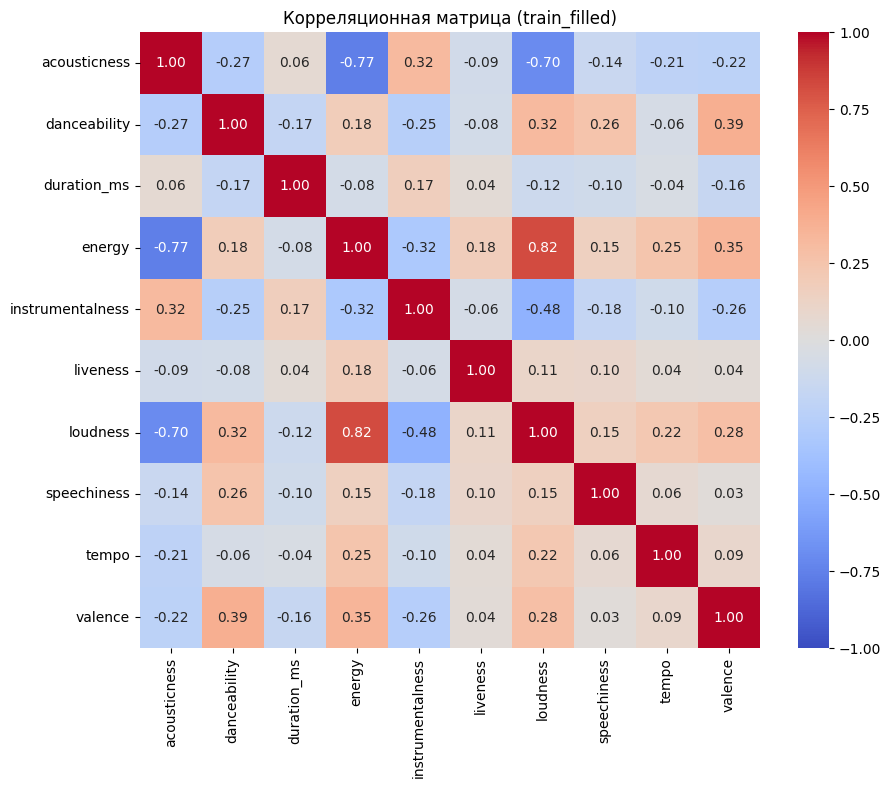

In [29]:
# @title Корреляционная матрица (train_filled)
numeric_cols_train = train_filled.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_filled[numeric_cols_train].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Корреляционная матрица (train_filled)')
plt.show()

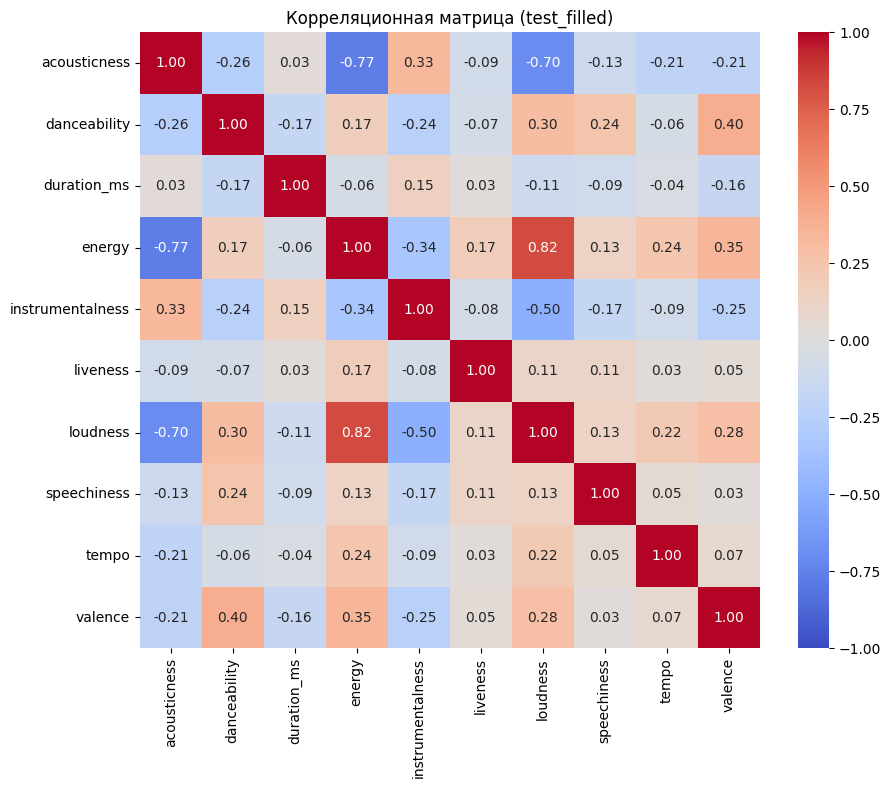

In [30]:
# @title Корреляционная матрица (test_filled)
numeric_cols_test = test_filled.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = test_filled[numeric_cols_test].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Корреляционная матрица (test_filled)')
plt.show()



> 1. Energy & Loudness (Train 0,82 | Test 0,82)


> 2. Acousticness & Energy (Train -0.77 | Test -0.77)


> 3. Acousticness & Loudness (Train -0.70 | Test	-0.70)







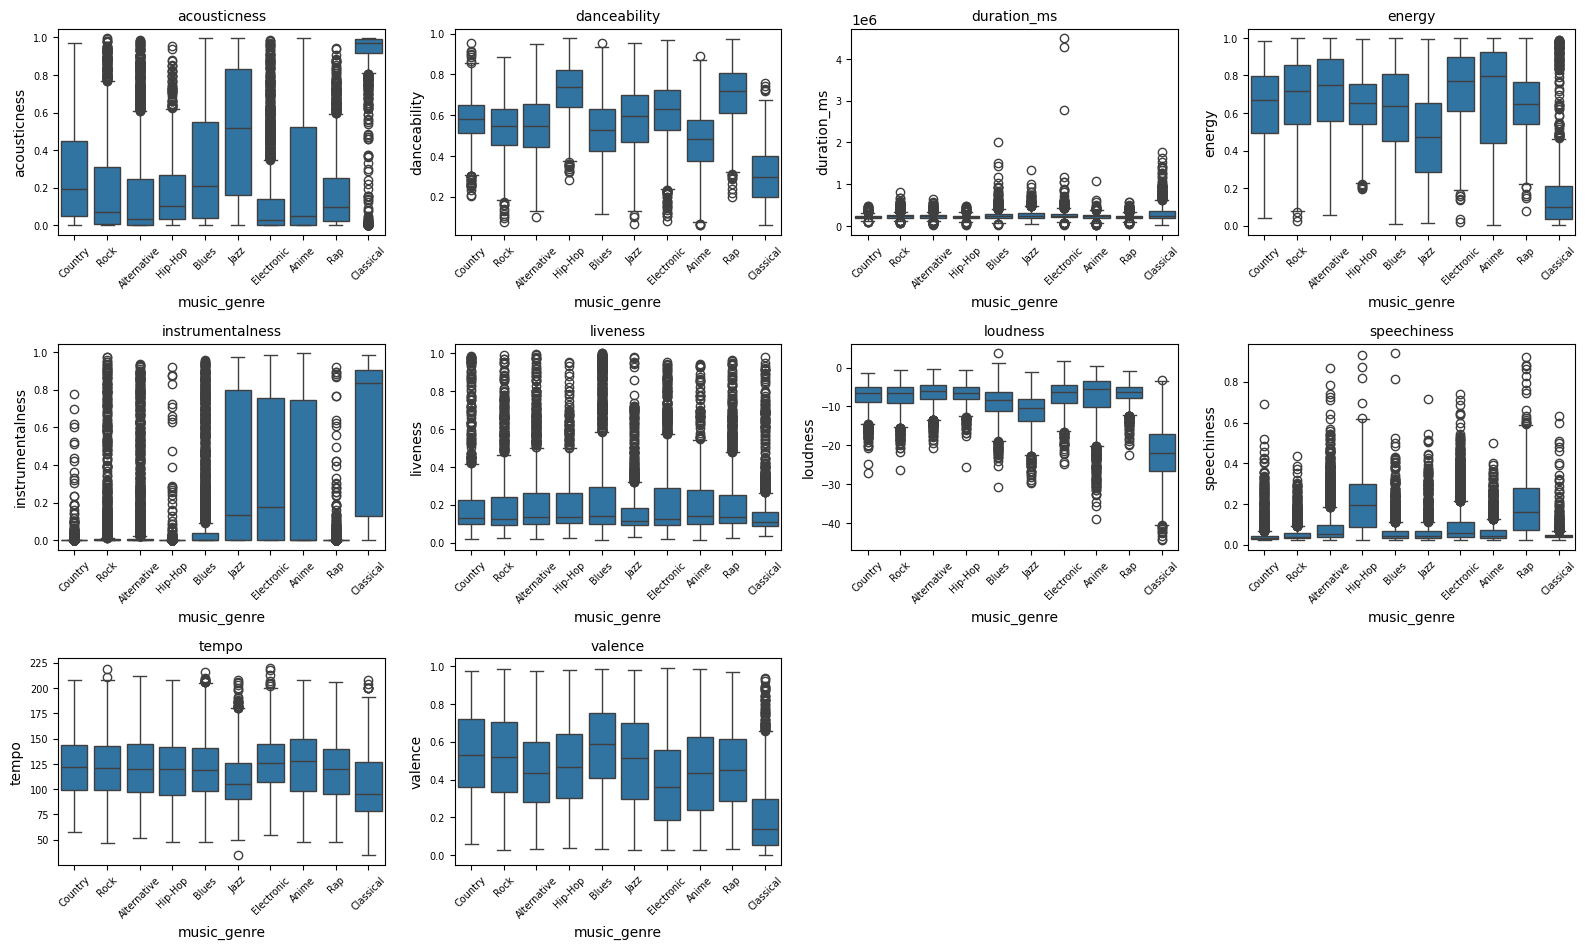

In [31]:
# @title Как признаки различают жанры
numeric_cols = train_filled.select_dtypes(include='number').columns.difference(['music_genre']).tolist()

n_plots = len(numeric_cols)
side = math.ceil(math.sqrt(n_plots))

fig, axes = plt.subplots(side, side, figsize=(side*4, side*3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(data=train_filled, x='music_genre', y=col, ax=ax)
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Сильные признаки**

> 1. speechiness


> 2. instrumentalness


> 3. acousticness







## Работа с признаками

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# копируем полный train_filled (включая track_name)
X = train_filled.copy()
y = X.pop('music_genre')

# синтетические числовые признаки
key_order = {'C':0,'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':9,'A#':10,'B':11}
mode_map  = {'Major':1, 'Minor':0}

for df in (X, test_filled):
    df['duration_sec']         = df['duration_ms'] / 1000
    df['log_duration']         = np.log1p(df['duration_sec'])
    df['sqrt_duration']        = np.sqrt(np.maximum(df['duration_sec'], 0))
    df['energy_dance']         = df['energy'] * df['danceability']
    df['valence_energy']       = df['valence'] * df['energy']
    df['liveness_speechiness'] = df['liveness'] * df['speechiness']
    df['speech_instr_sum']     = df['speechiness'] + df['instrumentalness']
    df['loudness_energy_ratio']  = df['loudness'] / (df['energy'] + 1e-6)
    df['acoustic_energy_ratio']  = df['acousticness'] / (df['energy'] + 1e-6)
    df['loudness_duration']      = df['loudness'] * df['duration_sec']
    df['tempo_low']            = (df['tempo'] <  90).astype(int)
    df['tempo_mid']            = ((df['tempo'] >= 90) & (df['tempo'] < 150)).astype(int)
    df['tempo_high']           = (df['tempo'] >= 150).astype(int)
    df['key_num']              = df['key'].map(key_order)
    df['mode_num']             = df['mode'].map(mode_map)

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_feats = [
    'duration_sec','log_duration','sqrt_duration',
    'energy_dance','valence_energy','liveness_speechiness',
    'speech_instr_sum','loudness_energy_ratio','acoustic_energy_ratio',
    'loudness_duration','tempo_low','tempo_mid','tempo_high',
    'key_num','mode_num'
]

# делаем временный split, чтобы не жечь весь X
X_tmp, _, y_tmp, _ = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
X_vif = X_tmp[num_feats].fillna(0)

vif_data = pd.DataFrame({
    'feature': num_feats,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(len(num_feats))]
}).sort_values('VIF', ascending=False)

print(vif_data)

                  feature          VIF
11              tempo_mid  4974.033855
10              tempo_low  1377.862497
12             tempo_high  1355.438904
2           sqrt_duration   246.165317
1            log_duration    94.838311
0            duration_sec    46.571205
8   acoustic_energy_ratio    38.191665
7   loudness_energy_ratio    36.375028
9       loudness_duration     3.966068
3            energy_dance     2.677700
4          valence_energy     1.959937
6        speech_instr_sum     1.280512
5    liveness_speechiness     1.070300
14               mode_num     1.045589
13                key_num     1.028761


In [34]:
to_drop = [
    'tempo_low','tempo_mid',        # оставляем только tempo_high
    'duration_sec','sqrt_duration', # оставляем только log_duration
    'acoustic_energy_ratio',
    'loudness_energy_ratio'
]

for df in (X, X_tmp, test_filled):
    df.drop(columns=to_drop, inplace=True, errors='ignore')

In [35]:
for df in (X, test_filled):
    df['title_len']      = df['track_name'].str.len()
    df['title_word_cnt'] = df['track_name'].str.split().apply(len)
    df['has_remix']      = df['track_name'].str.contains('remix', case=False).astype(int)
    df['has_live']       = df['track_name'].str.contains('live',  case=False).astype(int)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=y
)

from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.compose         import ColumnTransformer
from sklearn.decomposition   import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline        import Pipeline

cat_cols = ['key','mode']
text_col = 'track_name'
num_cols = [c for c in X_train.columns if c not in cat_cols + [text_col]]

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=500,
        ngram_range=(1,2),
        token_pattern=r"(?u)\b\w+\b"
    )),
    ('svd',   TruncatedSVD(n_components=50, random_state=RANDOM_STATE))
])

preprocessor = ColumnTransformer([
    ('ohe',   OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(),                      num_cols),
    ('text',  text_pipe,                             text_col),
])

## Выбор и обучение моделей

In [37]:
from sklearn.base             import TransformerMixin
from sklearn.ensemble         import RandomForestClassifier, StackingClassifier
from sklearn.linear_model     import LogisticRegression
from catboost                 import CatBoostClassifier
from lightgbm                 import LGBMClassifier

class ToDenseTransformer(TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        return X.toarray() if hasattr(X, "toarray") else X

cb_base   = CatBoostClassifier(
    iterations=300, learning_rate=0.1, depth=6,
    eval_metric='MultiClass', random_seed=RANDOM_STATE,
    verbose=0, auto_class_weights='Balanced'
)
rf_base   = RandomForestClassifier(
    n_estimators=300, max_depth=8,
    class_weight='balanced', n_jobs=-1,
    random_state=RANDOM_STATE
)
lgbm_base = LGBMClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    class_weight='balanced', random_state=RANDOM_STATE
)
lr_base   = LogisticRegression(
    class_weight='balanced', max_iter=1000,
    random_state=RANDOM_STATE
)

stack_clf = StackingClassifier(
    estimators=[
        ('catboost',     cb_base),
        ('random_forest',rf_base),
        ('lightgbm',     lgbm_base),
        ('logistic',     lr_base)
    ],
    final_estimator=LogisticRegression(
        class_weight='balanced', max_iter=1000,
        random_state=RANDOM_STATE
    ),
    cv=3, n_jobs=-1, passthrough=True
)

model_pipeline = Pipeline([
    ('preproc',  preprocessor),
    ('to_dense', ToDenseTransformer()),
    ('stack',    stack_clf)
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['key', 'mode']),
                                                 ('scale', StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'log_duration',
                                                   'energy_dance',
                                                   'valence_energy',
                                                   'liveness_speechiness',
                                                   'speec...
                                                                        n_estimators=300,
                                                                        n_jobs=-1,
                                                                        random_state=42)),
                                                ('lightgbm',
                                                 LGBMClassifier(class_weight='balanced',
                                                                max_depth=6,
                                                                n_estimators=300,
                                                                random_state=42)),
                                                ('logistic',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1, passthrough=True))])

## Оценка качества

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Weighted F1 (stacking): 0.47822282713319963
              precision    recall  f1-score   support

 Alternative       0.36      0.29      0.32       650
       Anime       0.58      0.62      0.60       471
       Blues       0.51      0.47      0.49       713
   Classical       0.89      0.84      0.86       342
     Country       0.46      0.59      0.52       529
  Electronic       0.66      0.62      0.64       639
     Hip-Hop       0.28      0.46      0.35       286
        Jazz       0.36      0.54      0.43       309
         Rap       0.50      0.42      0.45       606
        Rock       0.25      0.16      0.20       539

    accuracy                           0.48      5084
   macro avg       0.48      0.50      0.49      5084
weighted avg       0.49      0.48      0.48      5084



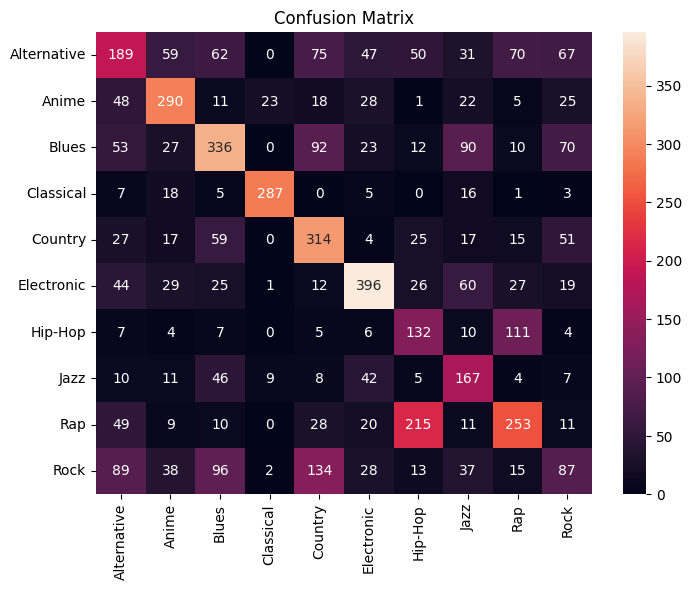

In [38]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_pipeline.predict(X_valid)
print("Weighted F1 (stacking):", f1_score(y_valid, y_pred, average='weighted'))
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred, labels=stack_clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=stack_clf.classes_,
            yticklabels=stack_clf.classes_)
plt.title('Confusion Matrix'); plt.show()

## Анализ важности признаков модели

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


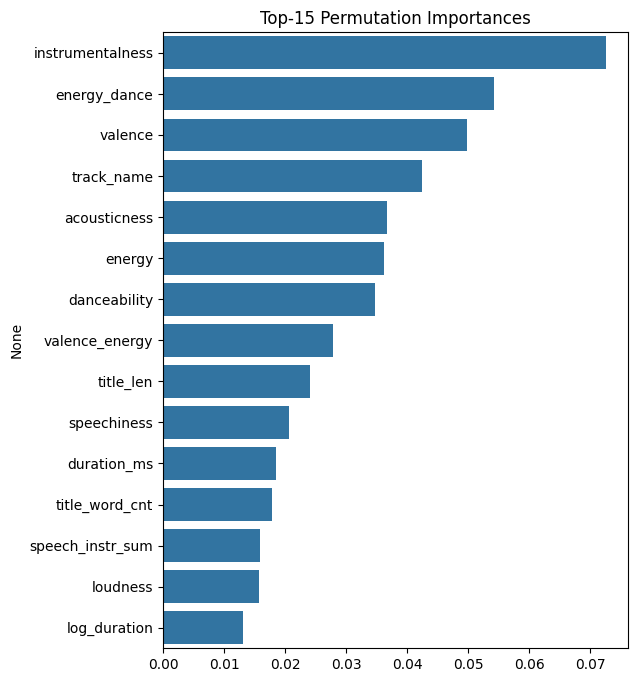

In [39]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model_pipeline, X_valid, y_valid,
    scoring='f1_weighted', n_repeats=5,
    random_state=RANDOM_STATE, n_jobs=-1
)

imp_df = pd.Series(perm.importances_mean, index=X_valid.columns).sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=imp_df.head(15).values, y=imp_df.head(15).index)
plt.title('Top-15 Permutation Importances'); plt.show()